In [8]:
# Common Libraries
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os
import sys
import json
import torch
import argparse
import gc
import time
import glob
import random
import ssl
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Astropy imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column
from astropy.nddata import Cutout2D
from astropy.visualization import make_lupton_rgb

# Detectron2 setup
import detectron2.utils.comm as comm
from detectron2.utils.logger import setup_logger
setup_logger()  # Setup Detectron2 logger
from detectron2.config import LazyConfig, get_cfg
from detectron2.engine import launch
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2 import structures
from detectron2.structures import BoxMode, Boxes
import detectron2.data as d2data

# DeepDisc imports
from deepdisc.data_format.image_readers import RomanImageReader
from deepdisc.data_format.register_data import register_data_set
from deepdisc.inference.predictors import return_predictor_transformer, get_predictions
from deepdisc.astrodet.visualizer import Visualizer, ColorMode
import deepdisc.astrodet.astrodet as toolkit  # For COCOEvaluatorRecall

# Matplotlib and other libraries
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from tqdm import tqdm

# Additional imports
import FoFCatalogMatching

In [ ]:
def get_scale_factors(orig_height, orig_width, target_size=512):
    """Calculates scale factors for upsampled images."""
    scale_x = orig_width / target_size
    scale_y = orig_height / target_size
    return scale_x, scale_y

def adjust_coordinates(x, y, scale_x, scale_y):
    """Scales down coordinates from upsampled image size to original WCS size."""
    return x * scale_x, y * scale_y

def get_truth_test_cat(test_data, scale=True):
    """
    Gets the RAs & Decs for the ground truth annotations from the test data

    Args:
        test_data (list): A list of dictionaries, where each dictionary contains
            image information and annotations
        scale (bool, optional): A flag indicating whether to apply scaling to the
            ground truth coordinates based on original image dimensions. default is True

    Returns:
        truth_cat (dict): dict w/ 'ra' and 'dec' keys containing RA and Dec coords of gt_objs
    """
    gt_ras = []
    gt_decs = []

    truth_info_cache = {}
    for d in test_data:
        imid = d['image_id']
        subpatch = d['subpatch']
        # temporary sol before I move all the corresponding correct WCS to the ups and pad dirs
        # right now only the lsst_data/truth dir has the updated WCS
        if subpatch not in truth_info_cache:
            truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
            with open(truth_info_filename) as json_data:
                truth_info_cache[subpatch] = json.load(json_data)

        truth_info = truth_info_cache[subpatch]
        entry = next(entry for entry in truth_info if entry['image_id'] == imid)
        if entry is None:
            print(f"Warning: No truth info found for image_id {imid} in subpatch {subpatch}")
            continue
        wcs = WCS(entry['wcs'])
        orig_height, orig_width = entry['height'], entry['width']

        # grab ground truth
        gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
        if gt_boxes.shape[0] != 0:
            gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            gt_boxes = Boxes(torch.Tensor(gt_boxes))
            centers_gt = gt_boxes.get_centers().cpu().numpy()

            if scale:
                scale_x, scale_y = get_scale_factors(orig_height, orig_width)
                adj_centers_gt = np.array([adjust_coordinates(x, y, scale_x, scale_y) for x, y in centers_gt])
                gt_coords = wcs.pixel_to_world(adj_centers_gt[:, 0], adj_centers_gt[:, 1])
            else:
                gt_coords = wcs.pixel_to_world(centers_gt[:, 0], centers_gt[:, 1])

            gt_ras.append(gt_coords.ra.degree)
            gt_decs.append(gt_coords.dec.degree)
        else:
            print(f"{d['file_name']} has no objects in its annotations!")

    # turn them into dicts
    truth_cat = {'ra': np.hstack(gt_ras), 'dec': np.hstack(gt_decs)}
    
    return truth_cat

def match_with_truth(det_cat, truth_cat, max_sep=0.5*u.arcsec):
    """
    Match detection catalog with truth catalog with search around sky
    Only keep 1-to-1 matches within max_sep
    """
    if len(det_cat) == 0:
        return pd.DataFrame(), pd.DataFrame()

    det_coords = SkyCoord(ra=det_cat['ra']*u.deg, 
                         dec=det_cat['dec']*u.deg)
    truth_coords = SkyCoord(ra=truth_cat['ra'].to_numpy()*u.deg, 
                           dec=truth_cat['dec'].to_numpy()*u.deg)
    
    idx_det, d2d, _ = det_coords.match_to_catalog_sky(truth_coords)
    good_sep = d2d <= max_sep
    # count how many truth objs match to each det and keep 1-to-1 matches
    unique_truth, truth_counts = np.unique(idx_det[good_sep], return_counts=True)
    good_truth = unique_truth[truth_counts == 1]
    
    final_mask = good_sep & np.isin(idx_det, good_truth)
    matched_det_indices = np.where(final_mask)[0]
    matched_truth_indices = idx_det[final_mask]
    
    matched_det = det_cat.iloc[matched_det_indices].copy()
    matched_truth = truth_cat.iloc[matched_truth_indices].copy()
    
    print(f"Found {len(matched_det)} matched pairs")
    
    return matched_det, matched_truth

# Getting Test.json's RAs and DECs and truth info

In [62]:
folder = 'annotations'

In [63]:
test_data_fi = f'lsst_data/{folder}/test.json'
with open(test_data_fi, 'r') as f:
    test_data = json.load(f)

In [69]:
test_truth_cat = get_truth_test_cat(test_data, scale=False)
# test_truth_cat = get_truth_test_cat(test_data) # upsampled

In [70]:
test_truth_cat_df = pd.DataFrame(test_truth_cat)
# test_truth_cat_df.to_json(f'./lsst_data/{folder}/test_truth_cat.json', orient='records')

In [71]:
test_truth_cat_df

,ra,dec
0,51.555857,-40.008120
1,51.556793,-40.004563
2,51.560856,-40.005226
3,51.560413,-40.001226
4,51.556944,-40.007452
...,...,...
7319,55.050461,-41.876986
7320,55.051667,-41.883104
7321,55.052466,-41.877886
7322,55.049503,-41.883092


In [ ]:
plt.scatter(test_truth_cat_df['ra'], test_truth_cat_df['dec'], s=1, c=['green'])
plt.xlabel('RA')
plt.ylabel('Dec')

In [3]:
# If using notebook, hard to load in the below due to not having enough memory on HAL
# lsst_truth = pd.read_jsoe('/home/shared/hsc/roman_lsst/lsst_catalogs/lsst_truth_cat_all_otp_morph.json')

# so I instead just extracted the ras and decs, all the id info and the mag from the above file and created the _radec2 file
lsst_truth = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/lsst_truth_cat_all_otp_morph_radec2.json')
len(lsst_truth) 

# in script, still load in the full morph file to ensure you have the full morphological info

3135126

In [4]:
lsst_truth.columns

Index(['ra', 'dec', 'cosmodc2_id', 'id', 'truth_type', 'mag_i'], dtype='object')

In [5]:
lsst_det = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/lsst_det_cat_all_overlap_patches.json')
# lsst_det = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/lsst_det_cat_all_overlap_patches_radec2.json')
len(lsst_det)

710439

In [16]:
lsst_det.columns

Index(['tract', 'psf_fwhm_y', 'patch', 'parentObjectId', 'mag_u',
       'mag_y_cModel', 'psf_fwhm_r', 'y', 'ra', 'mag_r_cModel', 'mag_z_cModel',
       'psf_fwhm_i', 'psf_fwhm_u', 'good', 'extendedness', 'objectId',
       'mag_i_cModel', 'snr_y_cModel', 'mag_z', 'mag_i', 'mag_g_cModel',
       'snr_g_cModel', 'snr_z_cModel', 'dec', 'x', 'psf_fwhm_g', 'mag_g',
       'snr_u_cModel', 'mag_r', 'blendedness', 'snr_i_cModel', 'snr_r_cModel',
       'clean', 'psf_fwhm_z', 'mag_u_cModel', 'mag_y'],
      dtype='object')

In [10]:
matched_det, matched_truth = match_with_truth(lsst_det, lsst_truth)

Found 690774 matched pairs


In [72]:
# when folder is annotations
matched_det, matched_truth = match_with_truth(test_truth_cat_df, lsst_truth)

Found 7274 matched pairs


The number of matched pairs should be exactly as many objects as there exists in `test_truth_cat_df` (7324) since `test.json` is supposed to be made with the annotations code that uses the truth folder which should contain all the objects from the truth catalog per cutout. This could indicate that the `obj_catalog` stored as a field for each cutout in the `{subpatch}_info.json` file is incomplete and doesn't actually contain all the objects within each cutout. We might have to revisit this and see why this is happening

In [61]:
# when folder is annotationsc-ups
matched_det, matched_truth = match_with_truth(test_truth_cat_df, lsst_truth)

Found 6686 matched pairs


Text(0, 0.5, 'Dec')

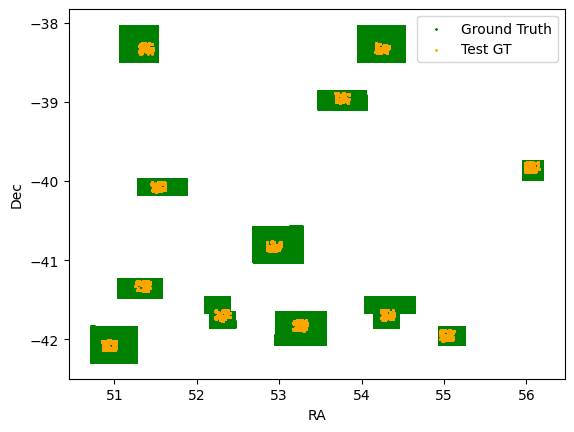

In [11]:
# plt.scatter(lsst_truth['ra_truth_merged'], lsst_truth['dec_truth_merged'], s=1, c=['green'], label='Ground Truth')
plt.scatter(lsst_truth['ra'], lsst_truth['dec'], s=1, c=['green'], label='Ground Truth')
plt.scatter(test_truth_cat_df['ra'], test_truth_cat_df['dec'], s=1, c=['orange'], label='Test GT')#, alpha=0.1)
plt.legend()
plt.xlabel('RA')
plt.ylabel('Dec')
# plt.ylim(-41.26, -41.3)
# plt.xlim(51.24, 51.30)

# Get Model Predictions

In [9]:
class ModelEvaluator:
    def __init__(self, run_dir, output_dir, test_data_file, cfg_file, model_path):
        """Initialize the ModelEvaluator.
        Args:
            run_dir (str): Directory containing model checkpoints
            output_dir (str): Directory for evaluation outputs
            test_data_file (str): Path to test data JSON file
            cfg_file (str): Path to model config file
        """
        self.run_dir = run_dir
        self.output_dir = output_dir
        self.test_data_file = test_data_file
        self.cfg_file = cfg_file
        self.model_path = model_path
        self.imreader = RomanImageReader()
        
        # default params
        self.topk_per_img = 2000
        self.score_thresh = 0.3
        self.nms_thresh = 0.4
        
        self.cfg = None
        self.predictor = None
        self.test_data = None
        self.registered_test_data = None
        


    def set_thresholds(self, topk=None, score=None, nms=None):
        """Set detection thresholds.
        
        Args (Defaults set in instantiation):
            topk (int): Top-k predictions per image. 
            score (float): Score threshold
            nms (float): NMS threshold
        """
        if topk is not None:
            self.topk_per_img = topk
        if score is not None:
            self.score_thresh = score
        if nms is not None:
            self.nms_thresh = nms

    def load_model(self):
        """Load model configuration and checkpoint."""
        if self.model_path is not None:
            model_path = self.model_path
        else:
            # finding model checkpoint
            pth_files = glob.glob(os.path.join(self.run_dir, '*.pth'))
            model_path = None
            for pth in pth_files:
                if "instances" not in pth:
                    model_path = pth
                    break
#             model_path = './lsst_runs/run5_sm_dlvl5/lsst_dlvl5.pth' # lsst_dlvl5.pth 
#         model_path = './lsst_runs/run5_ups_roman_dlvl5/lsstc_ups_dlvl5.pth'

        if not model_path:
            raise ValueError(f"No valid checkpoint file found in {self.run_dir}")
            
        print(f"Using checkpoint file: {model_path}")
        
        # loading config
        print(f"\nLoading configs from {self.cfg_file}...")
        self.cfg = LazyConfig.load(self.cfg_file)
        for key in self.cfg.get("MISC", dict()).keys():
            self.cfg[key] = self.cfg.MISC[key]
            
        # model params
        self.cfg.train.init_checkpoint = model_path
        for box_predictor in self.cfg.model.roi_heads.box_predictors:
            box_predictor.test_topk_per_image = self.topk_per_img
            box_predictor.test_score_thresh = self.score_thresh
            box_predictor.test_nms_thresh = self.nms_thresh
            
        # initialize predictor
        self.predictor = return_predictor_transformer(self.cfg)
    
    def load_test_data(self):
        """Load and register test dataset."""
        print(f"\nLoading test data from {self.test_data_file}...")
        with open(self.test_data_file, 'r') as f:
            self.test_data = json.load(f)
        
        # Force re-registration
        # Remove the dataset and its metadata first, if they exist.
        # This prevents the AssertionError when registering again.
        dataset_name = 'test'
        print(f"Attempting to remove existing registration for '{dataset_name}'...")
        if dataset_name in DatasetCatalog.list():
            DatasetCatalog.remove(dataset_name)
            print(f"Removed '{dataset_name}' from DatasetCatalog.")
        # It's important to remove from MetadataCatalog too!
        if dataset_name in MetadataCatalog.list():
            MetadataCatalog.remove(dataset_name)
            print(f"Removed '{dataset_name}' from MetadataCatalog.")
        try:
            custom_colors = [
                (0, 255, 0),    # green for galaxies
                (0, 0, 255),    # blue for stars
            ]
            print(f"Registering dataset '{dataset_name}'...")
            self.registered_test_data = register_data_set('test', 
                            self.test_data_file, 
                            thing_classes=["galaxy", "star"]).set(thing_colors=custom_colors)
        except AssertionError:
            print("\nTest dataset already registered")
            

    
    def get_test_data(self):
        if not self.test_data:
            raise ValueError("Load in the test data and register the dataset first! You can use load_test_data().")
        return self.test_data
    
    def evaluate(self):
        """Evaluate model performance on test dataset.
        
        Returns:
            dict: Evaluation results
        """
        if not all([self.cfg, self.predictor]):
            raise ValueError("Model not loaded. Call load_model() first.")
            
        mapper = self.cfg.dataloader.train.mapper(
            self.cfg.dataloader.imagereader, 
            img_key_mapper
        ).map_data
        
        evaluator = toolkit.COCOEvaluatorRecall(
            'test',
            use_fast_impl=True,
            output_dir=self.output_dir,
            allow_cached_coco=False
        )
        
        eval_loader = d2data.build_detection_test_loader(
            self.cfg,
            'test',
            mapper=mapper
        )
        
        results = inference_on_dataset(
            self.predictor.model,
            eval_loader,
            evaluator
        )
        
        return results
    
    
    def get_predictions(self, scale=False, trunc=False):
        """Uses model to predict on the test data 
        
        Args:
            scale (boolean): Default is false since the WCS is for the smaller images. But, we need this to be able to scale up the RAs and DECs accordingly for the upsampled images
        
        Returns:
            predictions (dict): A catalog containing RAs, DECs of every predicted object along with the filenames, imgid and subpatch
        """
        if not all([self.imreader, self.test_data, self.cfg, self.predictor]):
            raise ValueError("Model not loaded. Call load_model() first. \
                             OR ModelEvaluator not instantiated. Create an ModelEvaluator object first \
                             OR Load in test data using load_test_data()")    
        pred_ras = []
        pred_decs = []
        imgids = []
        subpatches = []
        filenames = []
        full_outputs = []

        truth_info_cache = {}
        for d in tqdm(self.test_data, desc="Getting predictions"):
#         for d in self.test_data:
            imid = d['image_id']
            filename = d['file_name']
            # temporary sol before I move all the corresponding correct WCS to the ups and pad dirs
            # right now only the truth dir has the updated WCS
            subpatch = d['subpatch']
            if trunc and d['wcs'] is not None:
                wcs = WCS(d['wcs'])
                if scale:
                    orig_height, orig_width = d['height'], d['width']
                    scale_x, scale_y = get_scale_factors(orig_height, orig_width)
            else:
                if subpatch not in truth_info_cache:
                    truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
                    with open(truth_info_filename) as json_data:
                        truth_info_cache[subpatch] = json.load(json_data)

                truth_info = truth_info_cache[subpatch]
                # grab the WCS
                entry = next(entry for entry in truth_info if entry['image_id'] == imid)
                wcs = WCS(entry['wcs'])
                if scale:
                    orig_height, orig_width = entry['height'], entry['width']
                    scale_x, scale_y = get_scale_factors(orig_height, orig_width)
            # print(wcs)

            # grab model's predictions
            outputs = get_predictions(d, self.imreader, img_key_mapper, self.predictor)
            raw_instances = outputs['instances']
            centers_pred = raw_instances.pred_boxes.get_centers().cpu().numpy()
            if scale:
                adj_centers_pred = np.array([adjust_coordinates(x, y, scale_x, scale_y) for x, y in centers_pred])
                pred_coords = wcs.pixel_to_world(adj_centers_pred[:,0], adj_centers_pred[:,1])
            else:
                pred_coords = wcs.pixel_to_world(centers_pred[:,0],centers_pred[:,1])
            # extend all lists with prediction info
            n_preds = len(centers_pred)
            pred_ras.extend(pred_coords.ra.degree)
            pred_decs.extend(pred_coords.dec.degree)
            imgids.extend([imid] * n_preds)
            subpatches.extend([subpatch] * n_preds)
            filenames.extend([filename] * n_preds)
            
            serializable_instance_data = {}
            if raw_instances.has('pred_boxes'):
                serializable_instance_data['pred_boxes'] = raw_instances.pred_boxes.tensor.cpu().numpy().tolist()
            if raw_instances.has('scores'):
                serializable_instance_data['scores'] = raw_instances.scores.cpu().numpy().tolist()
            if raw_instances.has('pred_classes'):
                serializable_instance_data['pred_classes'] = raw_instances.pred_classes.cpu().numpy().tolist()
#             if raw_instances.has('pred_masks'):
#                 # size implications for masks
#                 serializable_instance_data['pred_masks'] = raw_instances.pred_masks.cpu().numpy().tolist()
            serializable_instance_data['image_id'] = imid 
            serializable_instance_data['file_name'] = filename
            full_outputs.append(serializable_instance_data)

        # turn them into dicts
        dd_det_cat = {
            'ra': np.array(pred_ras),
            'dec': np.array(pred_decs),
            'image_id': np.array(imgids),
            'subpatch': np.array(subpatches),
            'file_name': np.array(filenames)
        }
        
        return dd_det_cat, full_outputs
    
    def get_random_prediction(self, random_img):
        outputs = get_predictions(random_img,  self.imreader, img_key_mapper, self.predictor)
        return outputs
    
    def get_lsst_det_mask(self, lsst_det_coords, scale=False):
        all_bounds = []
        truth_info_cache = {}
        for d in tqdm(self.test_data, desc="Getting LSST Detections within each cutout"):
            imid = d['image_id']
            filename = d['file_name']
            subpatch = d['subpatch']
            scale_x = None
            scale_y = None
            wcs = None
            height = d['height']
            width = d['width']
            if "wcs" in d and d['wcs'] is not None:
                wcs = WCS(d['wcs'])
                if scale:
                    orig_height, orig_width = d['height'], d['width']
                    scale_x, scale_y = get_scale_factors(orig_height, orig_width)
            else:
                if subpatch not in truth_info_cache:
                    truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
                    with open(truth_info_filename) as json_data:
                        truth_info_cache[subpatch] = json.load(json_data)

                truth_info = truth_info_cache[subpatch]
                # grab the WCS
                entry = next(entry for entry in truth_info if entry['image_id'] == imid)
                wcs = WCS(entry['wcs'])
                if scale:
                    orig_height, orig_width = entry['height'], entry['width']
                    scale_x, scale_y = get_scale_factors(orig_height, orig_width)
            
            # corner coords
            # top left (0,0) top right (511, 0) bottom left (0, 511) bottom right (511, 511)
            corners_x = [0, width - 1, 0, width - 1]  # bc upsampled img is 512x512
            corners_y = [0, 0, height - 1, height - 1]
            if scale:
                adj_corners_x, adj_corners_y = zip(*[adjust_coordinates(x, y, scale_x, scale_y) for x, y in zip(corners_x, corners_y)])
                corners = wcs.pixel_to_world(adj_corners_x, adj_corners_y)
            else:
                corners = wcs.pixel_to_world(corners_x, corners_y)

            all_bounds.append(corners)      

        mask = np.zeros(len(lsst_det_coords), dtype=bool)
        for bounds in all_bounds:
            ra_min, ra_max = np.min(bounds.ra), np.max(bounds.ra)
            dec_min, dec_max = np.min(bounds.dec), np.max(bounds.dec)

            mask |= ((lsst_det_coords.ra >= ra_min) & (lsst_det_coords.ra <= ra_max) &
                     (lsst_det_coords.dec >= dec_min) & (lsst_det_coords.dec <= dec_max))

        return mask
        
    def run_full_evaluation(self):
        """Run full evaluation pipeline.
        
        Returns:
            dict: Evaluation results
        """
        self.load_model()
        self.load_test_data()
        return self.evaluate()


In [ ]:
folder = 'annotationsc-ups'
# scale based on random shape size in test data or put in metadata
scale = True
run_dir = 'run5_ups_roman_dlvl5'
# cfg_file = "./deepdisc/configs/solo/swin_lsst.py"
cfg_file = "./deepdisc/configs/solo/swinc_lsst_ups.py"
model_path = './lsst_runs/run5_ups_roman_dlvl5/lsstc_ups_dlvl5.pth'
test_score_thresh = 0.3
nms = 0.5
output_dir = run_dir
test_data_file = f'./lsst_data/{folder}/test.json'


evaluator = ModelEvaluator(
    run_dir=run_dir,
    output_dir=output_dir,
    test_data_file=test_data_file,
    cfg_file=cfg_file,
    model_path=model_path
)
# 0.45 0.5 was used for that AstroFest plot comparison of unrecognized blends
evaluator.set_thresholds(topk=2000, score=test_score_thresh, nms=nms)
evaluator.load_model()
evaluator.load_test_data()
test_data = evaluator.get_test_data()

## Getting Roman + LSST Model Predictions on Random Img

Setting colors


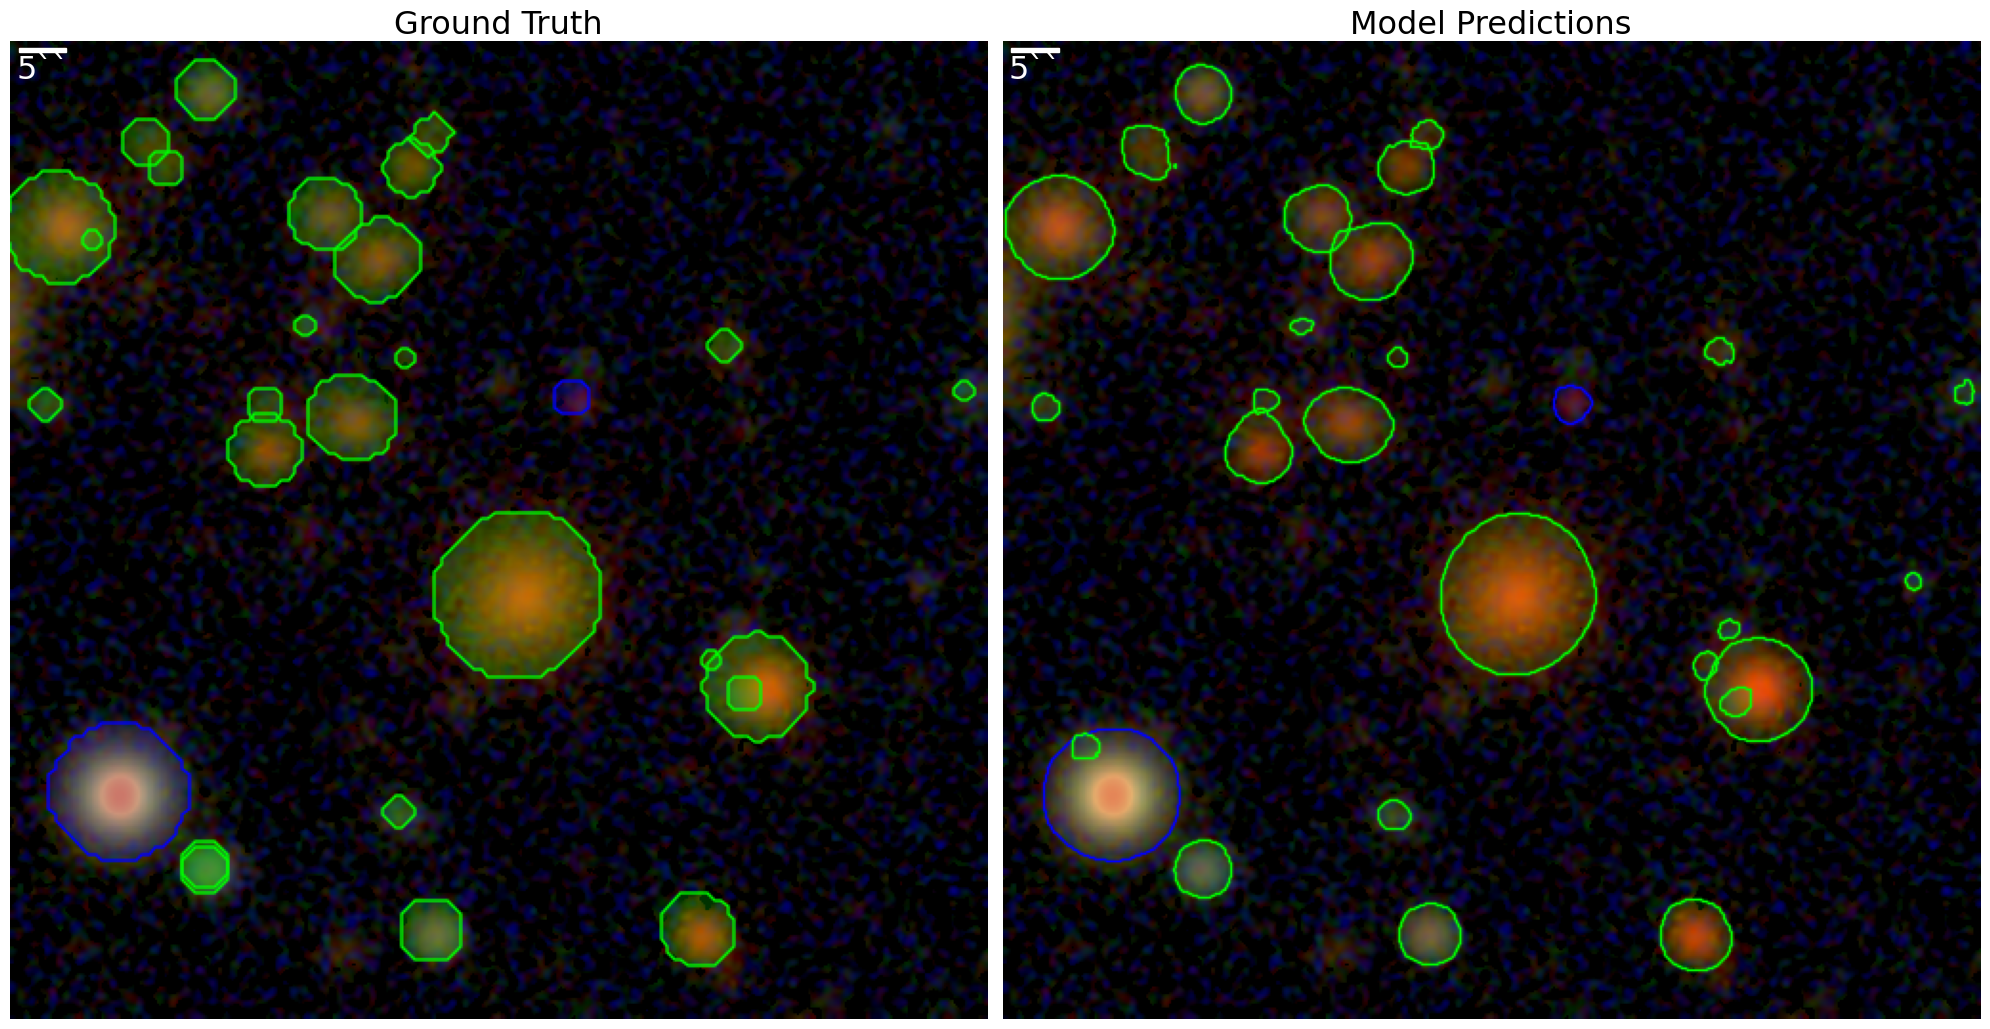

In [7]:
fontprops = fm.FontProperties(size=23)

random_img = test_data[6] # "/home/yse2/lsst_data/truthc-ups/dc2_53.75_-38.9/full_c252_53.75_-38.9.npy"
key = img_key_mapper(random_img)
img = evaluator.imreader._read_image(key)
# img = make_lupton_rgb(img[:,:,2], img[:,:,3], img[:,:,4], minimum=0, stretch=50, Q=10)
img = make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0], minimum=0, stretch=0.5, Q=10)
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
for ax in axes:
    ax.axis("off")


v_gt = Visualizer(
    img.copy(),
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,
    enable_color_jitter=False
)

axes[0].set_title("Ground Truth", fontsize=23)
# print(random_img['file_name'])
ground_truth = v_gt.draw_dataset_dict(random_img, lf=False,alpha=0.2, boxf=False)
axes[0].imshow(ground_truth.get_image())

v = Visualizer(
    img,
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,# remove the colors of unsegmented pixels. This option is only available for segmentation models
    enable_color_jitter=False
)
# print(v.enable_color_jitter)
axes[1].set_title("Model Predictions",fontsize=23)
outputs = evaluator.get_random_prediction(random_img)
prediction_output = v.draw_instance_predictions(outputs["instances"].to("cpu"), alpha=0.1,lf=False)
axes[1].imshow(prediction_output.get_image())

scalebar = AnchoredSizeBar(axes[0].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[0].add_artist(scalebar)


scalebar = AnchoredSizeBar(axes[1].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[1].add_artist(scalebar)

# axes[1].scatter(175.618416,247.179605,color='w',s=5)

plt.tight_layout()

# # save if needed
# output_path = os.path.join(run_dir, f"det_gt_{random_idx}.png")
# plt.savefig(output_path)
# print(f"Plots saved to {output_path}")
# filter out test set if obj extends beyond cutout
# center of obj outside cutout -> done by doing cut by filtering by bounds
# center is within cutout but bbdox is large enough such that it goes into a diff cutout -> check if bbox brushes up against the edge of the cutout
# figure out how many objs are truncated by analyzing the bbox coords and make a new cutout for that obj and run inference on the new test set

## Getting LSST Model Predictions on Random Img

In [163]:
with open('./lsst_data/annotations/all_metadata.json', 'r') as f:
    all_data = json.load(f)

In [165]:
filename = '/home/yse2/lsst_data/truth/dc2_53.75_-38.9/full_c252_53.75_-38.9.npy'
matching_entry = next((entry for entry in all_data if entry['file_name'] == filename), None)
if matching_entry:
    # Do something with the matching entry
    print("Found")
#     print(matching_entry)

Found


/home/yse2/lsst_data/truth/dc2_53.75_-38.9/full_c252_53.75_-38.9.npy
Setting colors


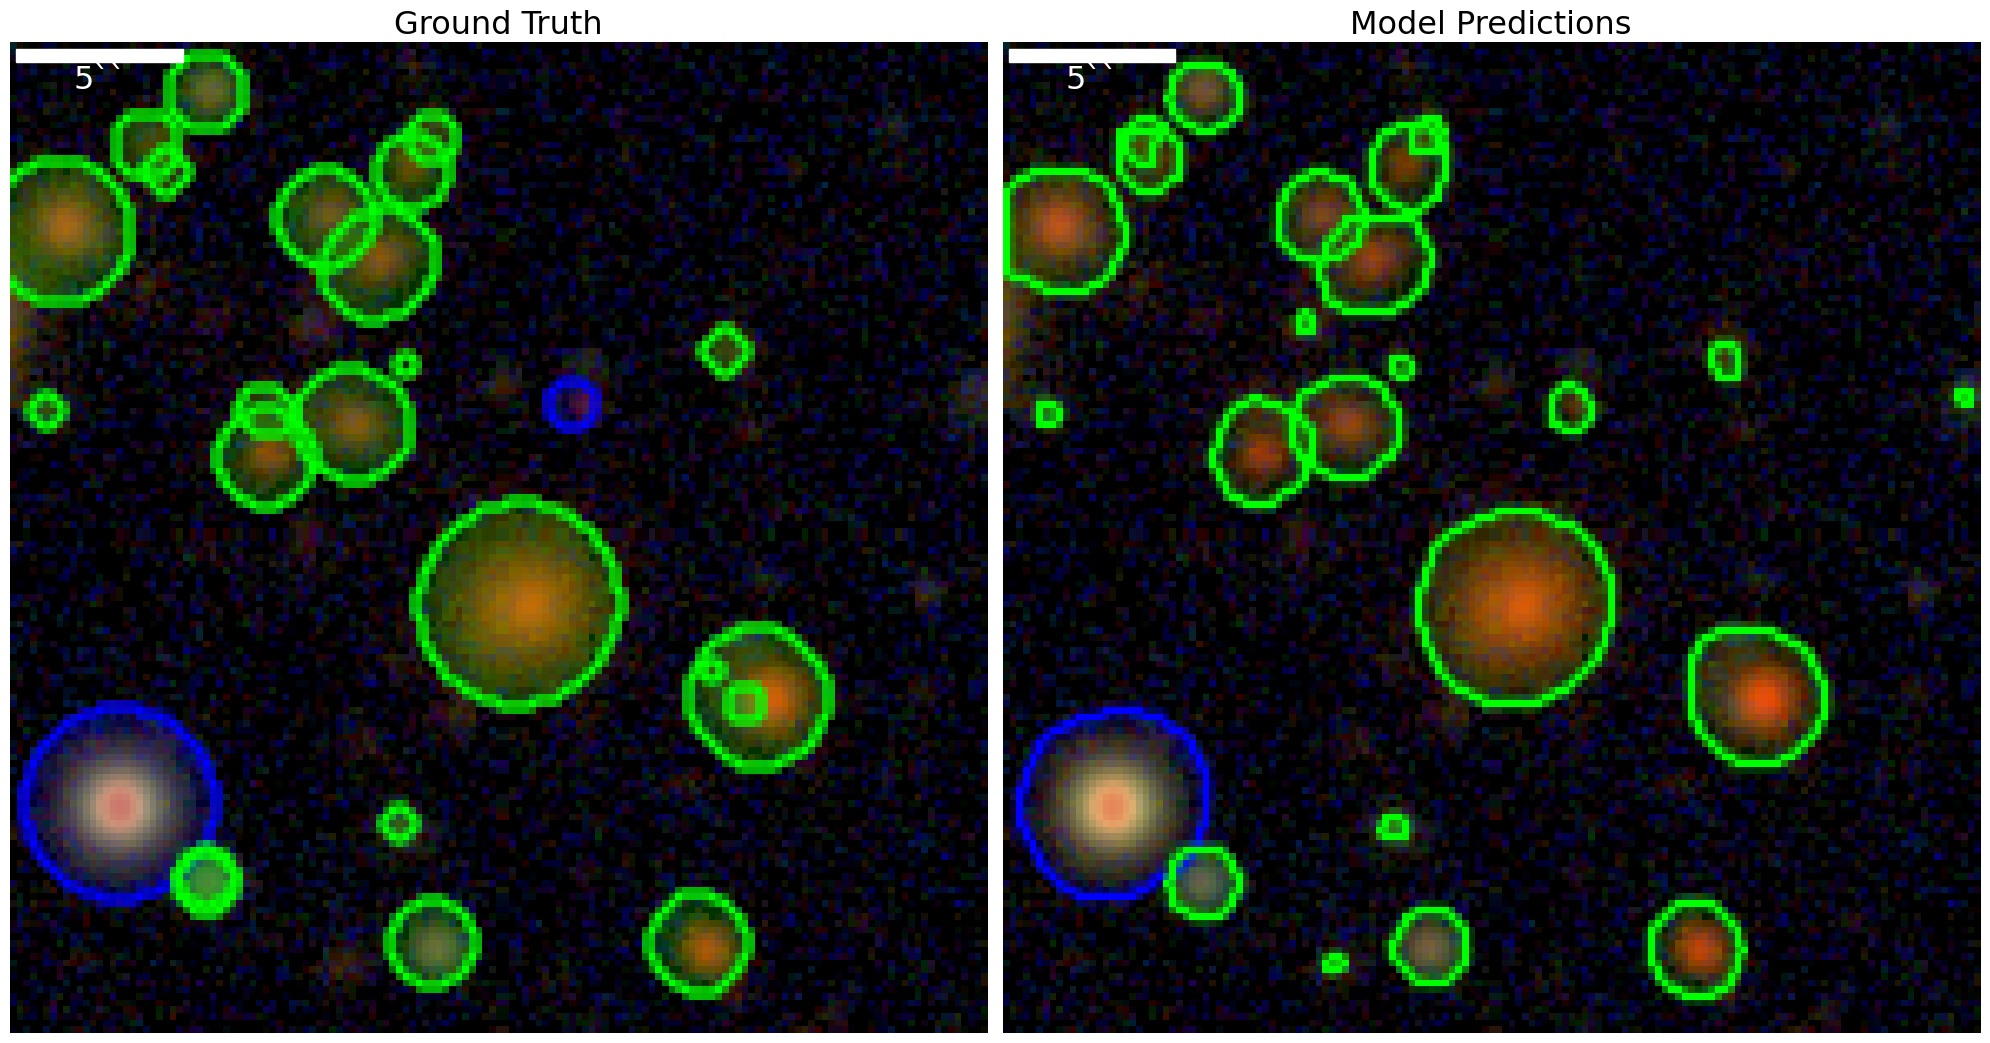

In [174]:
fontprops = fm.FontProperties(size=23)

# random_img = test_data[10]
random_img = matching_entry
print(random_img['file_name'])
key = img_key_mapper(random_img)
img = evaluator.imreader._read_image(key)
# img = make_lupton_rgb(img[:,:,2], img[:,:,3], img[:,:,4], minimum=0, stretch=50, Q=10)
img = make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0], minimum=0, stretch=0.5, Q=10)
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
for ax in axes:
    ax.axis("off")


v_gt = Visualizer(
    img.copy(),
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,
    enable_color_jitter=False
)

axes[0].set_title("Ground Truth", fontsize=23)
# print(random_img['file_name'])
ground_truth = v_gt.draw_dataset_dict(random_img, lf=False,alpha=0.2, boxf=False)
axes[0].imshow(ground_truth.get_image())

v = Visualizer(
    img,
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,# remove the colors of unsegmented pixels. This option is only available for segmentation models
    enable_color_jitter=False
)
# print(v.enable_color_jitter)
axes[1].set_title("Model Predictions",fontsize=23)
outputs = evaluator.get_random_prediction(random_img)
prediction_output = v.draw_instance_predictions(outputs["instances"].to("cpu"), alpha=0.1,lf=False)
axes[1].imshow(prediction_output.get_image())

scalebar = AnchoredSizeBar(axes[0].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[0].add_artist(scalebar)


scalebar = AnchoredSizeBar(axes[1].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[1].add_artist(scalebar)

# axes[1].scatter(175.618416,247.179605,color='w',s=5)

plt.tight_layout()

# # save if needed
# output_path = os.path.join(run_dir, f"det_gt_{random_idx}.png")
# plt.savefig(output_path)
# print(f"Plots saved to {output_path}")
# filter out test set if obj extends beyond cutout
# center of obj outside cutout -> done by doing cut by filtering by bounds
# center is within cutout but bbdox is large enough such that it goes into a diff cutout -> check if bbox brushes up against the edge of the cutout
# figure out how many objs are truncated by analyzing the bbox coords and make a new cutout for that obj and run inference on the new test set

## Script Code - Getting All Predictions and Matching DeepDISC to Truth

In [ ]:
full_pred_output_file = f'./lsst_runs/{run_dir}/full_pred_output_s{test_score_thresh}_n{nms}.json'
predictions_file = f'./lsst_runs/{run_dir}/pred_s{test_score_thresh}_n{nms}.json'
dd_det_file = f'./lsst_runs/{run_dir}/pred_s{test_score_thresh}_n{nms}_radec.json'

if not os.path.exists(full_pred_output_file):
    # assuming if above file doesn't exist none of the other two exist
    print("Generating Model Predictions:")
    predictions, all_outputs = evaluator.get_predictions(scale=scale)
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_json(predictions_file, orient='records', indent=4)

    # list_of_serializable_outputs
    with open(full_pred_output_file, 'w') as f:
        json.dump(all_outputs, f, indent=4)
    print(f"Saved full prediction outputs (from Instances) to {full_pred_output_file}")

    print(f"Saved DeepDISC Predictions to {predictions_file} and {full_pred_output_file}")
    dd_det_df = pd.DataFrame({
        'ra': predictions['ra'],
        'dec': predictions['dec']
    })
    dd_det_df.to_json(dd_det_file, orient='records')
    print(f"Saved DeepDISC Predictions RA and DEC to {dd_det_file}")
else:
    predictions = pd.read_json(predictions_file, orient='records')
    dd_det_df = pd.read_json(dd_det_file, orient='records')

matched_dd_truth_filename = f'./lsst_runs/{run_dir}/dd_truth11_info_s{test_score_thresh}_n{nms}.json'
matched_dd_det_filename = f'./lsst_runs/{run_dir}/dd_det11_s{test_score_thresh}_n{nms}_radec.json'

if not os.path.exists(matched_dd_truth_filename):
    matched_dd_det, matched_dd_truth = match_with_truth(dd_det_df, matched_lsst_truth)
    matched_dd_det.to_json(matched_dd_det_filename, orient='records')
    matched_dd_truth.to_json(matched_dd_truth_filename, orient='records')
    print(f"File created: {matched_dd_truth_filename} and {matched_dd_det_filename}")
else:
    print(f"File already exists: {matched_dd_truth_filename} and {matched_dd_det_filename}")

# Getting Roman and LSST Detection Catalog Manually rather than SkyCoord matching Predictions

In [ ]:
# LSST First (from original metrics.ipynb)
lsst_all_test_det_filename = f'./lsst_runs/{run_dir}/test_lsst_det_fof_info.json'
if not os.path.exists(lsst_all_test_det_filename):
    lsst_det_coords = SkyCoord(ra=lsst_det['ra']*u.deg, dec=lsst_det['dec']*u.deg)
    mask = evaluator.get_lsst_det_mask(lsst_det_coords, scale=scale)
    filtered_lsst_det = lsst_det[mask]
    lsst_all_test_det = filtered_lsst_det.drop_duplicates(subset=['ra', 'dec'])
    lsst_all_test_det.to_json(lsst_all_test_det_filename, orient='records')
else:
    print(f"Files already exist: {lsst_all_test_det_filename}!")